# Tracking Mouse Hand SAM-Tracker Deom

In [1]:
input = 'assets/S21.mp4'

In [2]:
# !pip install -r requestment.txt

In [3]:
import os
import cv2
import imageio
import numpy as np
from PIL import Image
from tqdm import tqdm
from aot_tracker import _palette
from SegTracker import SegTracker
from matplotlib import pyplot as plt
from scipy.ndimage import binary_dilation

In [4]:
# Get First Frame
cap = cv2.VideoCapture(input)
_, first_frame = cap.read()
cap.release()

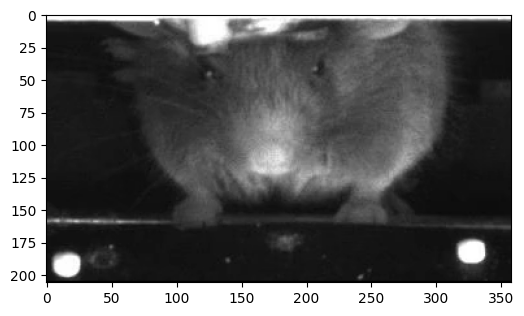

In [5]:
plt.figure(figsize=(6, 5))
plt.imshow(first_frame)
plt.show()
plt.close()

In [6]:
sam_args = {
    'sam_checkpoint': "ckpt/sam_vit_b_01ec64.pth",
    'model_type': "vit_b",
    'generator_args':{
        'points_per_side': 16,
        'pred_iou_thresh': 0.8,
        'stability_score_thresh': 0.9,
        'crop_n_layers': 1,
        'crop_n_points_downscale_factor': 2,
        'min_mask_region_area': 200,
    },
    'gpu_id': 'cpu',
}
aot_args = {
    'phase': 'PRE_YTB_DAV',
    'model': 'r50_deaotl',
    'model_path': 'ckpt/R50_DeAOTL_PRE_YTB_DAV.pth',
    'long_term_mem_gap': 250,
    'max_len_long_term': 250,
    'gpu_id': 'cpu',
}
segtracker_args = {
    'sam_gap': int(1e6), # the interval to run sam to segment new objects
    'min_area': 200, # minimal mask area to add a new mask as a new object
    'max_obj_num': 10, # maximal object number to track in a video
    'min_new_obj_iou': 0.8, # the background area ratio of a new object should > 80% 
}

In [7]:
segtracker = SegTracker(segtracker_args,sam_args,aot_args)
segtracker.restart_tracker()

No module named 'spatial_correlation_sampler'
Failed to import PyTorch Correlation, For better efficiency, please install it.
No module named 'spatial_correlation_sampler'
Failed to import PyTorch Correlation, For better efficiency, please install it.
No module named 'spatial_correlation_sampler'
Failed to import PyTorch Correlation, For better efficiency, please install it.
No module named 'spatial_correlation_sampler'
Failed to import PyTorch Correlation, For better efficiency, please install it.
No module named 'spatial_correlation_sampler'
Failed to import PyTorch Correlation, For better efficiency, please install it.
No module named 'spatial_correlation_sampler'
Failed to import PyTorch Correlation, For better efficiency, please install it.
SegTracker has been initialized


In [8]:
# Click First Frame
coords = np.array([[110,150], [115, 140]])
modes = np.array([1, 1])
mask, mask_with_frame = segtracker.seg_acc_click(first_frame, coords, modes)

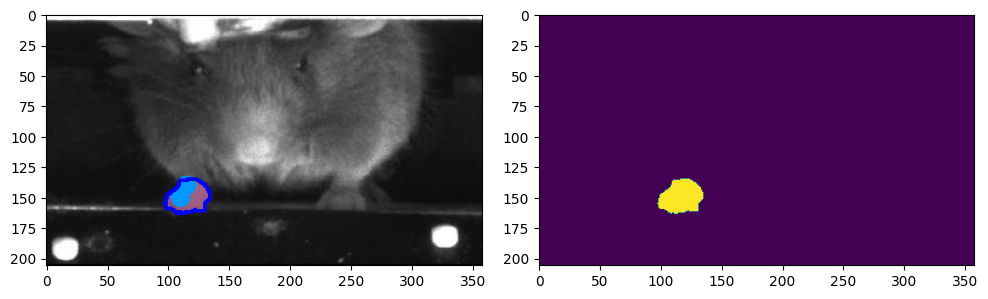

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(mask_with_frame)
plt.subplot(1,2,2)
plt.imshow(mask)
plt.tight_layout()
plt.show()
plt.close()

In [10]:
# Save object
segtracker.update_origin_merged_mask(mask)
segtracker.curr_idx += 1
del mask, mask_with_frame

In [11]:
# Click the other frame
coords = np.array([[245,150]])
modes = np.array([1])
mask, mask_with_frame = segtracker.seg_acc_click(first_frame, coords, modes)

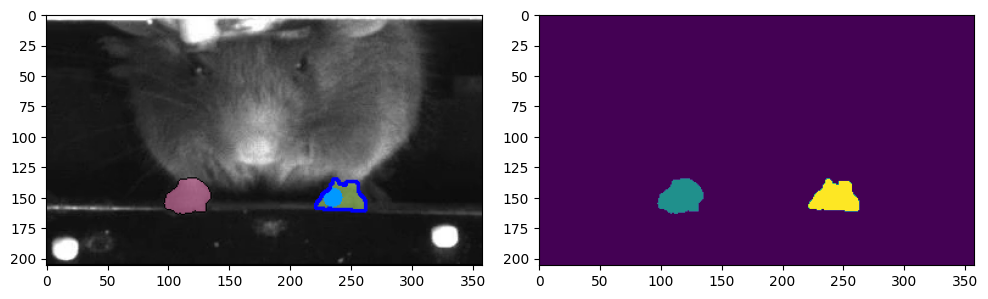

In [12]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(mask_with_frame)
plt.subplot(1,2,2)
plt.imshow(mask)
plt.tight_layout()
plt.show()
plt.close()

In [13]:
# Save object
segtracker.update_origin_merged_mask(mask)
segtracker.curr_idx += 1

segtracker.add_reference(first_frame, mask, 0)
segtracker.first_frame_mask = mask
del mask, mask_with_frame

/Users/raiso/Segment-and-Track-Anything-1/.venv/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [14]:
# Inference mask
masks = []
cap = cv2.VideoCapture(input)
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
n_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))


for i in tqdm(range(n_frame)):
    ok, frame = cap.read()
    assert ok, "[E] Read Frame Error"
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    if i == 0:
         mask = segtracker.first_frame_mask
    else:
        mask = segtracker.track(frame, update_memory=True)
    
    masks.append(mask)

cap.release()

  0%|          | 1/9600 [00:00<02:05, 76.25it/s]


RuntimeError: Invalid device, must be cuda device

In [ ]:
def build_putpalette(pred_mask):
    save_mask = Image.fromarray(pred_mask.astype(np.uint8))
    save_mask = save_mask.convert(mode='P')
    save_mask.putpalette(_palette)
    return save_mask

In [ ]:
fps = 80

In [ ]:
output = 'output.mp4'
fourcc =  cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(output, fourcc, fps, (width, height))

for it in tqdm(masks):
    masked_frame = build_putpalette(it).convert(mode='RGB') # type: PIL.Image.Image
    masked_frame = np.array(masked_frame) # type: numpy.ndarray
    masked_frame = cv2.cvtColor(masked_frame,cv2.COLOR_RGB2BGR)
    out.write(masked_frame)
    
out.release()